In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test

import seaborn as sns
sns.set(rc={'figure.figsize':[12,8]})

df = pd.read_pickle('STING_DB.pkl')
df.head()

n_patient           id label  array  n_cores          sp    sp_date  turb  \
0          1  19870070301    OO    935      1.0   05-S-9869 2005-12-07     4   
1          1  19870070301    OO    931      3.0  07-S-11432 2007-11-14     5   
2          1  19870070301    OO    931      3.0  07-S-11432 2007-11-14     5   
3          1  19870070301    OO    931      3.0  07-S-11432 2007-11-14     5   
4          1  19870070301    OO    931      3.0   05-S-4662 2005-06-10     3   

   histo      lesion  ... bcg_date mitomycin progression_stage_any  \
0      4   Non-tumor  ...      NaT         0                    No   
1      1   Low-grade  ...      NaT         0                    No   
2      1   Low-grade  ...      NaT         0                    No   
3      1   Low-grade  ...      NaT         0                    No   
4      2  High-grade  ...      NaT         0                    No   

  progression_stage_next recurrence_any  recurrence_next  \
0                    Yes            Yes              Yes   
1                     No            Yes               No   
2                     No            Yes               No   
3                     No            Yes               No   
4                     No            Yes               No   

   progression_grade_any  progression_grade_next   fu_months  sp_bcg_timing  
0                     No                     Yes  270.933333            Pre  
1                     No                      No  270.933333            Pre  
2                     No                      No  270.933333            Pre  
3                     No                      No  270.933333            Pre  
4                     No                      No  270.933333            Pre  

[5 rows x 64 columns]

In [2]:
# Creating the dataframe for survival regression
# Removing non-tumor and CIS spots
df.query('(lesion != "CIS") & (lesion != "Non-tumor")', inplace=True)
# Recoding outcomes for regression analysis
df['recurrence_any'].replace({'No':0,'Yes':1}, inplace=True)
df['progression_grade_any'].replace({'No':0,'Yes':1}, inplace=True)
df['progression_stage_any'].replace({'No':0,'Yes':1}, inplace=True)

In [3]:
# Summarizing marker expression using estimator values
# Only recurrence and progression at any time during follow-up were included
# (total follow-up time makes sense only in this context)
estimator = 'median'
df_survival = df.groupby('sp').agg({
    'sting_tumor':estimator,
    'sting_inflammatory':estimator,
    'cgas_tumor':estimator,
    'cgas_inflammatory':estimator,
    'pirf3_tumor':estimator,
    'pirf3_inflammatory':estimator,
    'fu_months':max,
    'recurrence_any':max,
    'progression_grade_any':max,
    'progression_stage_any':max
})
df_survival.dropna(inplace=True)
df_survival.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 01-S-10015 to 99-S-5927
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sting_tumor            65 non-null     float64
 1   sting_inflammatory     65 non-null     float64
 2   cgas_tumor             65 non-null     float64
 3   cgas_inflammatory      65 non-null     float64
 4   pirf3_tumor            65 non-null     float64
 5   pirf3_inflammatory     65 non-null     float64
 6   fu_months              65 non-null     float64
 7   recurrence_any         65 non-null     int64  
 8   progression_grade_any  65 non-null     int64  
 9   progression_stage_any  65 non-null     int64  
dtypes: float64(7), int64(3)
memory usage: 5.6+ KB


# Survival curves

## STING in tumor cells

In [4]:
marker = 'sting_tumor'

### Tumor recurrence

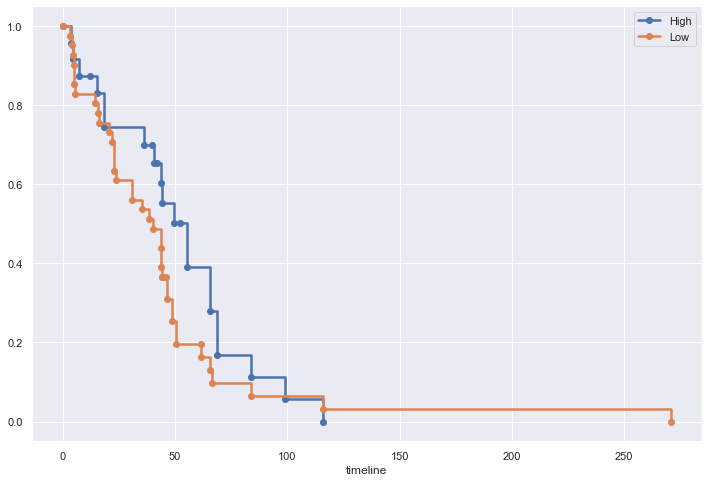

In [5]:
outcome = 'recurrence_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [6]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           1.90 0.17      2.58

### Grade progression

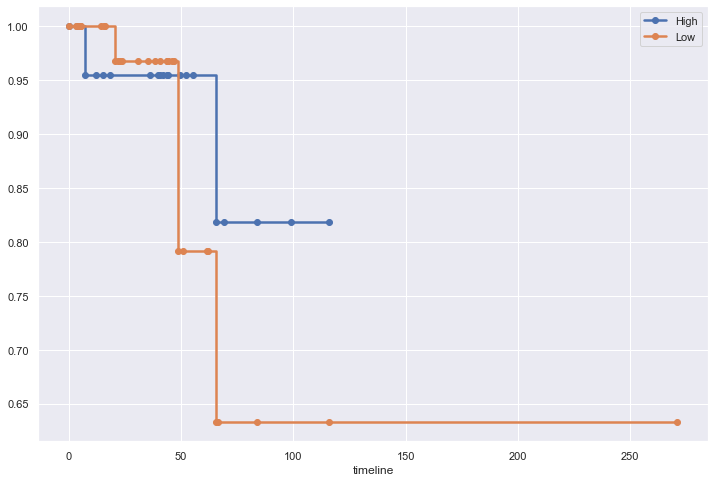

In [7]:
outcome = 'progression_grade_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [8]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.60 0.44      1.19

### Stage progression

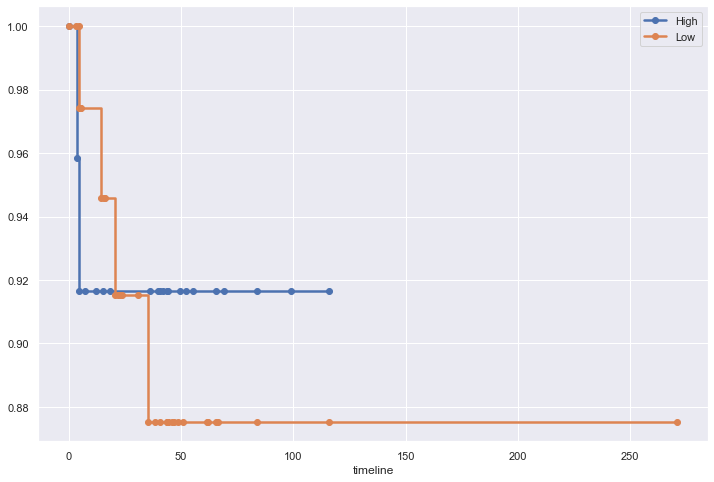

In [9]:
outcome = 'progression_stage_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [10]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.05 0.82      0.28

## STING in peritumoral lymphocytes

In [11]:
marker = 'sting_inflammatory'

### Tumor recurrence

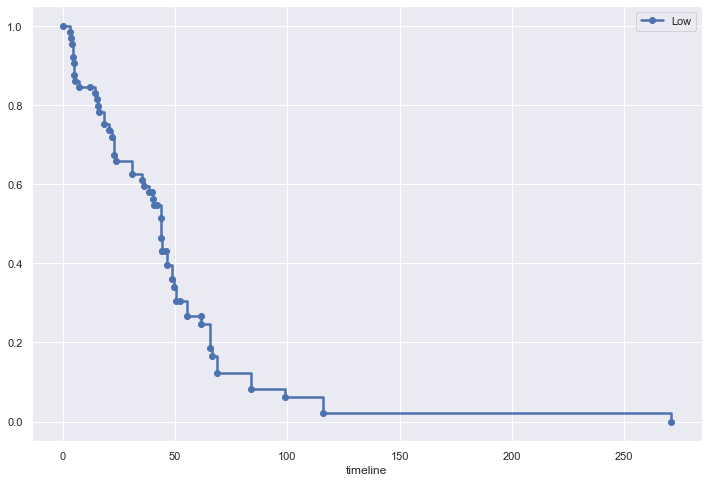

In [12]:
outcome = 'recurrence_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [13]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 0
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.00  nan       nan

### Grade progression

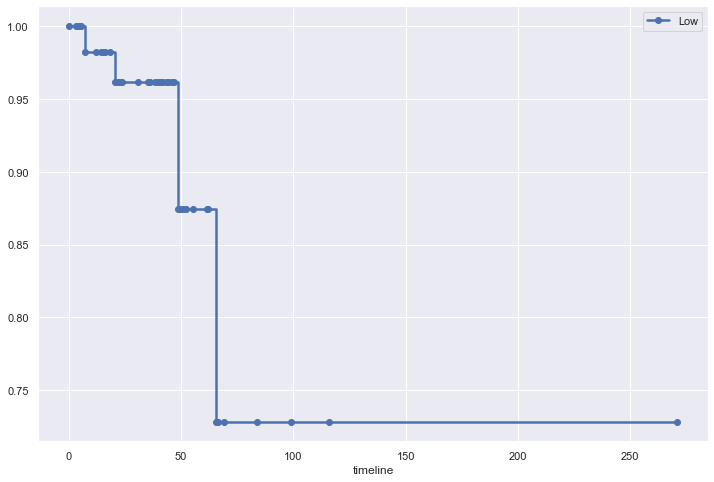

In [14]:
outcome = 'progression_grade_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [15]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 0
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.00  nan       nan

### Stage progression

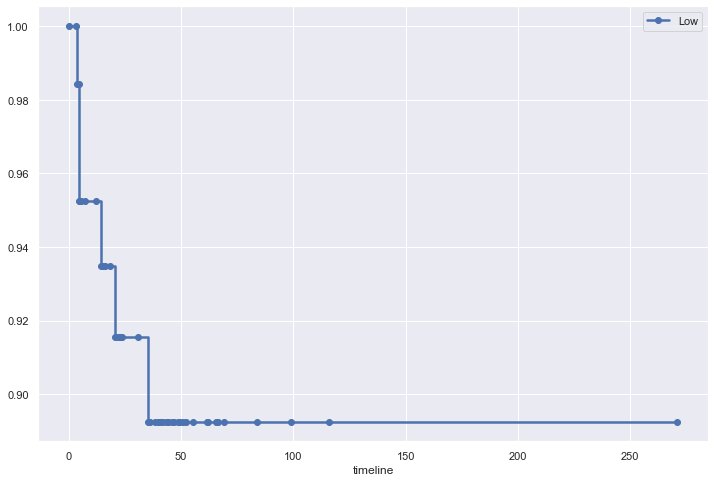

In [16]:
outcome = 'progression_stage_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [17]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 0
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.00  nan       nan

## cGAS in tumor cells

In [18]:
marker = 'cgas_tumor'

### Tumor recurrence

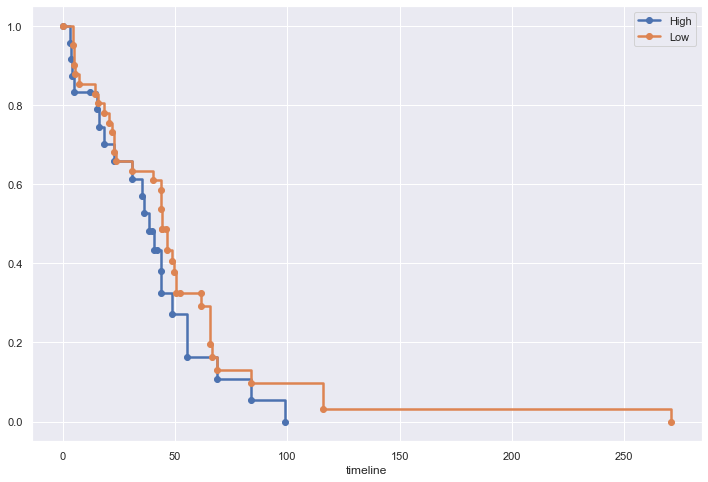

In [19]:
outcome = 'recurrence_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [20]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           1.48 0.22      2.16

### Grade progression

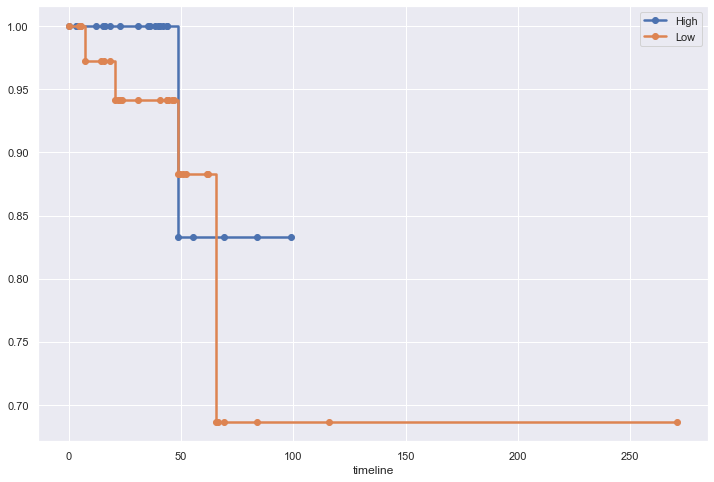

In [21]:
outcome = 'progression_grade_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [22]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.46 0.50      1.01

### Stage progression

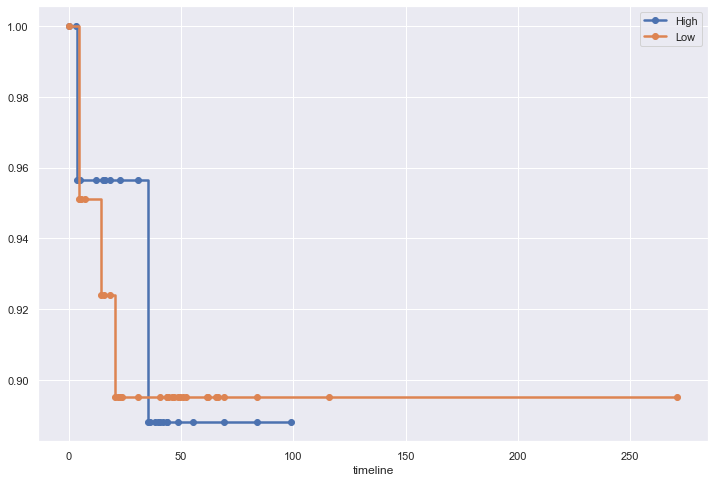

In [23]:
outcome = 'progression_stage_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [24]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.95      0.07

## cGAS in peritumoral lymphocytes

In [25]:
marker = 'cgas_inflammatory'

### Tumor recurrence

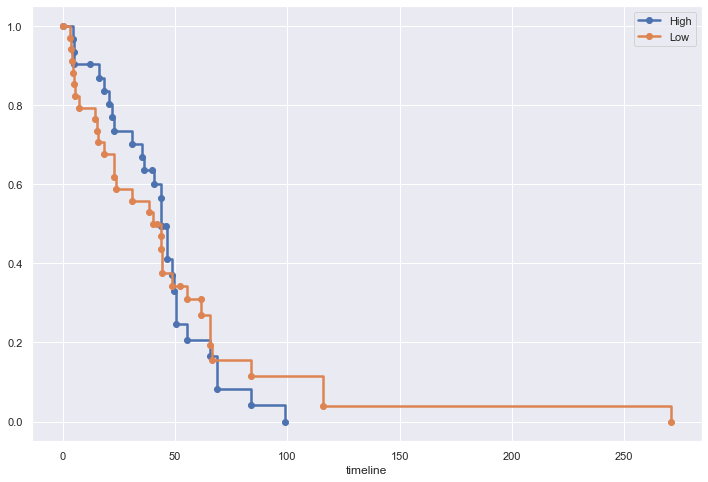

In [26]:
outcome = 'recurrence_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [27]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.05 0.82      0.28

### Grade progression

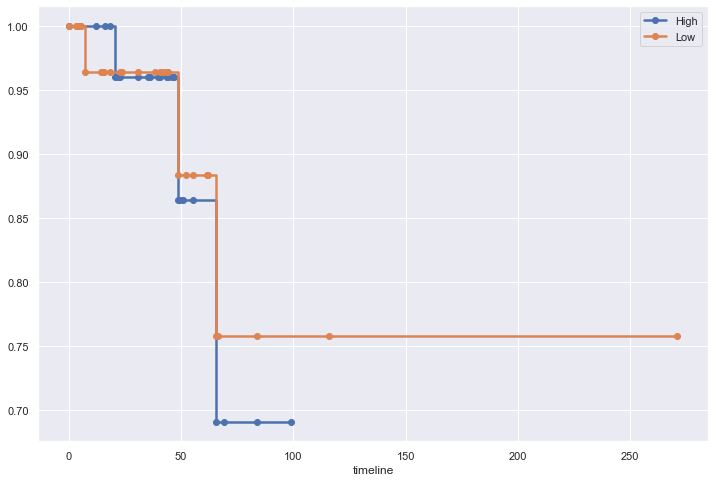

In [28]:
outcome = 'progression_grade_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [29]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.04 0.84      0.25

### Stage progression

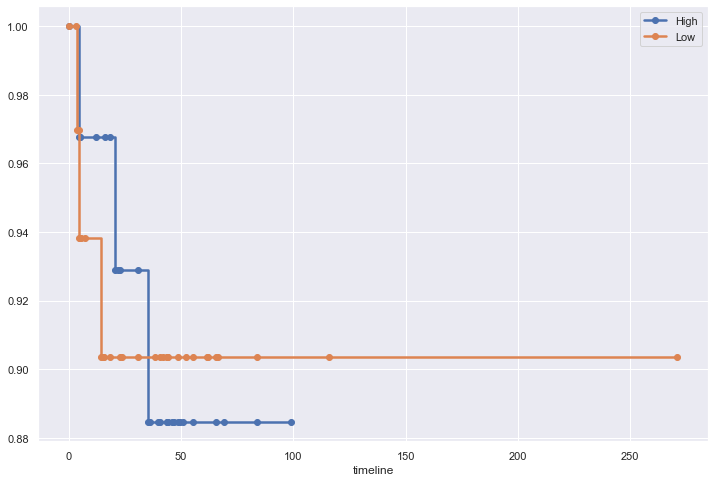

In [30]:
outcome = 'progression_stage_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [31]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.98      0.03

## pIRF3 in tumor cells

In [32]:
marker = 'pirf3_tumor'

### Tumor recurrence

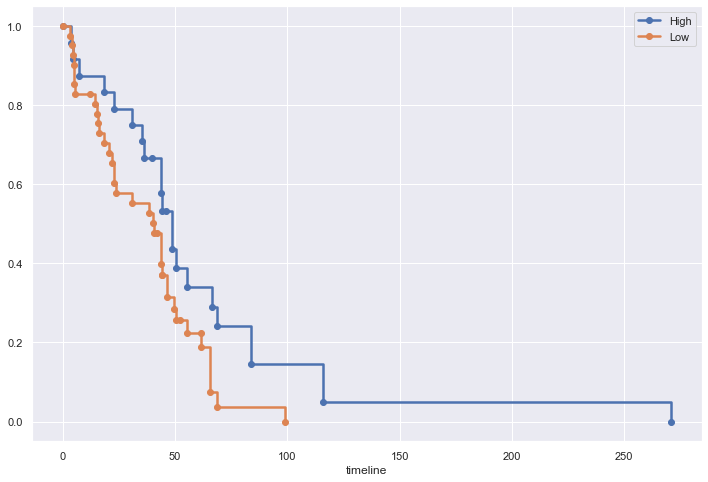

In [33]:
outcome = 'recurrence_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [34]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           4.19 0.04      4.62

### Grade progression

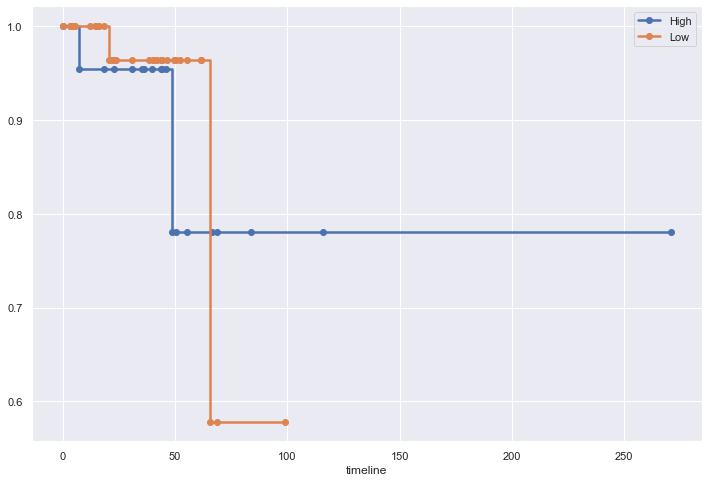

In [35]:
outcome = 'progression_grade_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [36]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.00 0.98      0.02

### Stage progression

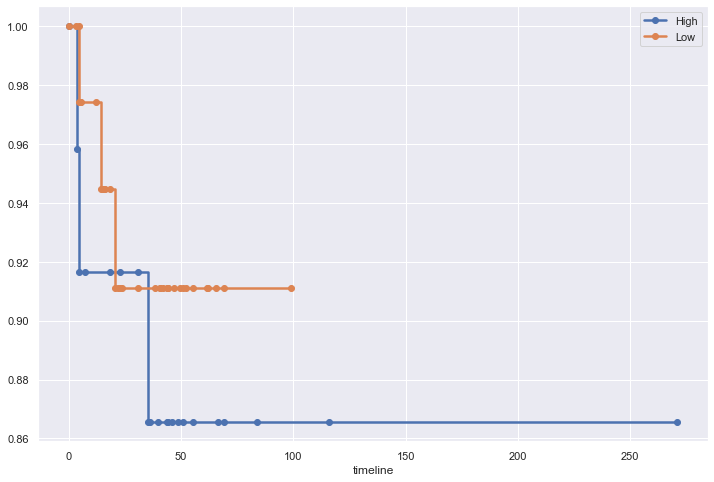

In [37]:
outcome = 'progression_stage_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [38]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.28 0.60      0.74

## pIRF3 in peritumoral lymphocytes

In [39]:
marker = 'pirf3_inflammatory'

### Tumor recurrence

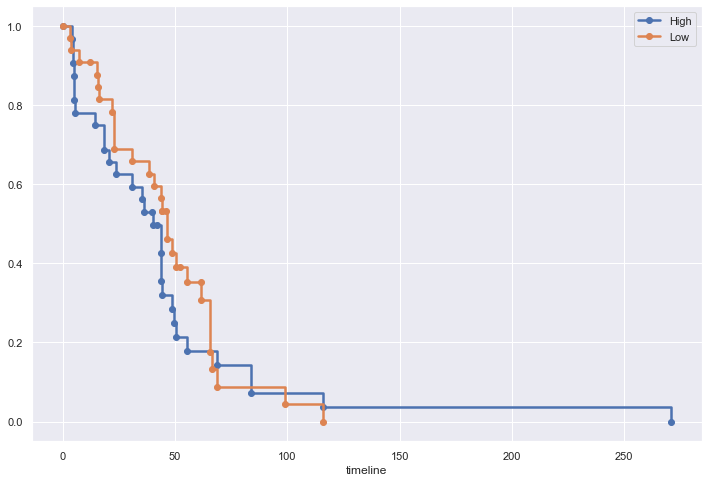

In [40]:
outcome = 'recurrence_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [41]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.52 0.47      1.08

### Grade progression

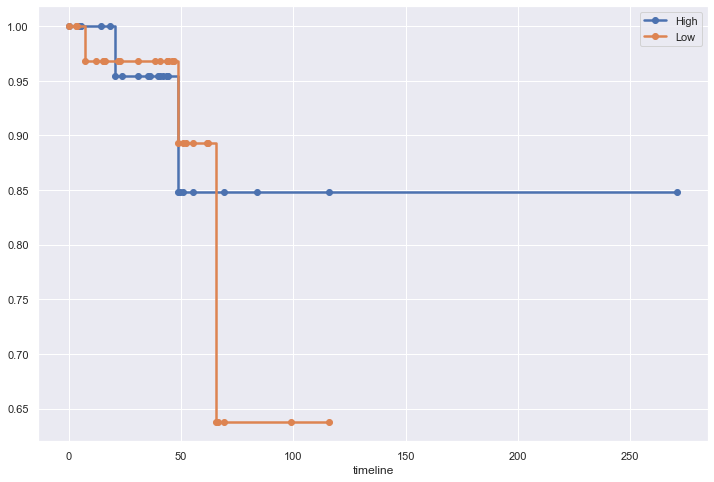

In [42]:
outcome = 'progression_grade_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [43]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.22 0.64      0.65

### Stage progression

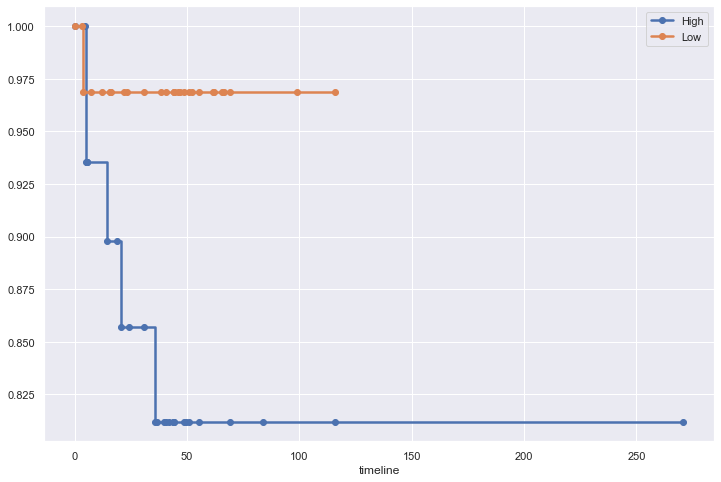

In [44]:
outcome = 'progression_stage_any'

# Creating new variables for marker level (low vs high) using the median as the cutoff point
df_survival['marker_level'] = df_survival[marker].apply(lambda x: 'High' if x > df_survival[marker].median() else 'Low')

# Plotting survival curves
kmf = KaplanMeierFitter()
for name, data in df_survival.groupby('marker_level'):
    kmf.fit(data['fu_months'], data[outcome], label=name)
    kmf.plot(ci_show=False, linewidth=2.5, marker='o')

In [45]:
# Comparing survival curves (log-rank test)
multivariate_logrank_test(df_survival['fu_months'], df_survival['marker_level'], df_survival[outcome])

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           2.97 0.08      3.56